In [1]:
import os, sys, time, copy
import wave
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE

from scipy.io import wavfile
from scipy.fft import fft, rfft, fftshift, fftfreq
from scipy.signal import convolve, freqz

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, HER, PPO, SAC, TD3
from stable_baselines3.common.base_class import BaseAlgorithm, VecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

sys.path.append('../')
from helper import to_min_size_int_array, Spectrum, LPF, apply_filter, mean_L1_dist, SNR
from DDPG import DDPGAgent

2023-10-31 09:43:07.993504: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 09:43:08.229460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 09:43:08.229570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 09:43:08.229938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 09:43:08.310798: I tensorflow/core/platform/cpu_feature_g

In [3]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

Box(-2.0, 2.0, (1,), float32)
..... saving models .....
episode:0, score:-1268.5589, avg score:-1268.5589
..... saving models .....
episode:1, score:-14.5233, avg score:-641.5411
..... saving models .....
episode:2, score:-15.6014, avg score:-432.8945
..... saving models .....
episode:3, score:-13.3349, avg score:-328.0046
..... saving models .....
episode:4, score:-11.0969, avg score:-264.6231
..... saving models .....
episode:5, score:-8.9225, avg score:-222.0063
..... saving models .....
episode:6, score:-6.9656, avg score:-191.2862
..... saving models .....
episode:7, score:-5.3329, avg score:-168.0421
..... saving models .....
episode:8, score:-4.0638, avg score:-149.8222
..... saving models .....
episode:9, score:-3.1454, avg score:-135.1546
..... saving models .....
episode:10, score:-2.5431, avg score:-8.553
..... saving models .....
episode:11, score:-2.2224, avg score:-7.3229
..... saving models .....
episode:12, score:-2.1666, avg score:-5.9794
..... saving models .....
epis

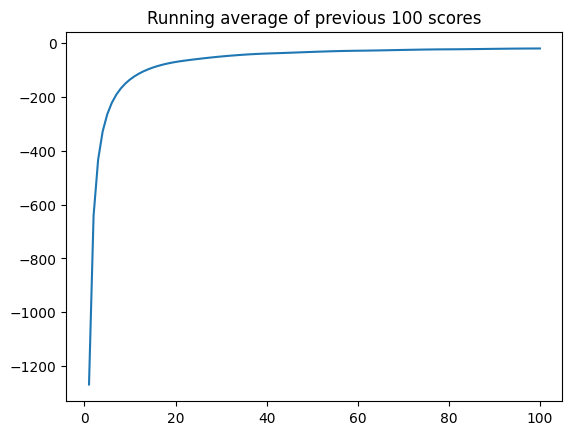

In [6]:
if __name__ == '__main__':
    env = gym.make('Pendulum-v1')
    print(env.action_space)
    agent = DDPGAgent(
        input_dims=env.observation_space.shape,
        n_actions=env.action_space.shape[0],
        alpha=0.001,
        beta=0.01,
        gamma=0.99,
        tau=0.0001,
        critic_fc1=10,
        critic_fc2=10,
        actor_fc1=10,
        actor_fc2=10,
        batch_size=16,
        noise=0.001
    )
    n_episodes = 100

    figure_file = 'plots/pendulum.png'
    best_score = env.reward_range[0] # minimum reward possible
    score_history = []
    load_checkpoint = False

    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation, _ = env.reset()
            action = env.action_space.sample()
            new_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            agent.remember(observation, action, reward, new_observation, done)
            n_steps += 1
        agent.learn()
        # your model is only going to completely created when learned
        # the input layer of the critic network is only initialized when started training. 
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    observation, _ = env.reset()
    for i in range(n_episodes):
        done = False
        score = 0
        while not done:
            action = agent.choose_action(observation, evaluate)
            new_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            score += reward
            agent.remember(observation, action, reward, new_observation, done)
            if not load_checkpoint:
                agent.learn()
            observation = new_observation
        score_history.append(score)
        avg_score = np.mean(score_history[-10:])

        if avg_score > best_score:
            best_score = avg_score
            if not load_checkpoint:
                agent.save_models()

        print(f"episode:{i}, score:{np.round(score, 4)}, avg score:{np.round(avg_score, 4)}")

    if not load_checkpoint:
        x = np.arange(1, 1+n_episodes)
        plot_learning_curve(x, score_history, figure_file)


In [4]:
# Let's first load the audio files
log_path = "audio_files/"
src_audio_name = 'vignesh'
target_audio_file = src_audio_name + '-target-MONO.wav'
jammed_audio_file = src_audio_name + '-jammed-MONO.wav'

if not os.path.exists(log_path+target_audio_file):
    raise Exception(f"the target audio signal, {log_path+target_audio_file}, doesn't exist.")
sampling_rate, target_signal = wavfile.read(log_path+target_audio_file)

if not os.path.exists(log_path+jammed_audio_file):
    raise Exception(f"the jammed audio signal, {log_path+jammed_audio_file}, doesn't exist.")
sampling_rate_, jammed_signal = wavfile.read(log_path+jammed_audio_file)

if sampling_rate != sampling_rate_:
    Exception(f"the two sampling rates are not equal, {sampling_rate} and {sampling_rate_}")
print(f"audio files have been successfully loaded: target - {log_path+target_audio_file}, jammed - {log_path+jammed_audio_file}")

# basic information 
print(f"sampling rate    : {sampling_rate} Hz")
print(f"number of samples: {len(target_signal)}")

audio files have been successfully loaded: target - audio_files/vignesh-target-MONO.wav, jammed - audio_files/vignesh-jammed-MONO.wav
sampling rate    : 44100 Hz
number of samples: 136476


### Points
- set the buffer size $S$ to some lower value like 50 to make the state space smaller.

seperation between two sub-sequences: 13647 (<class 'numpy.uint32'>)


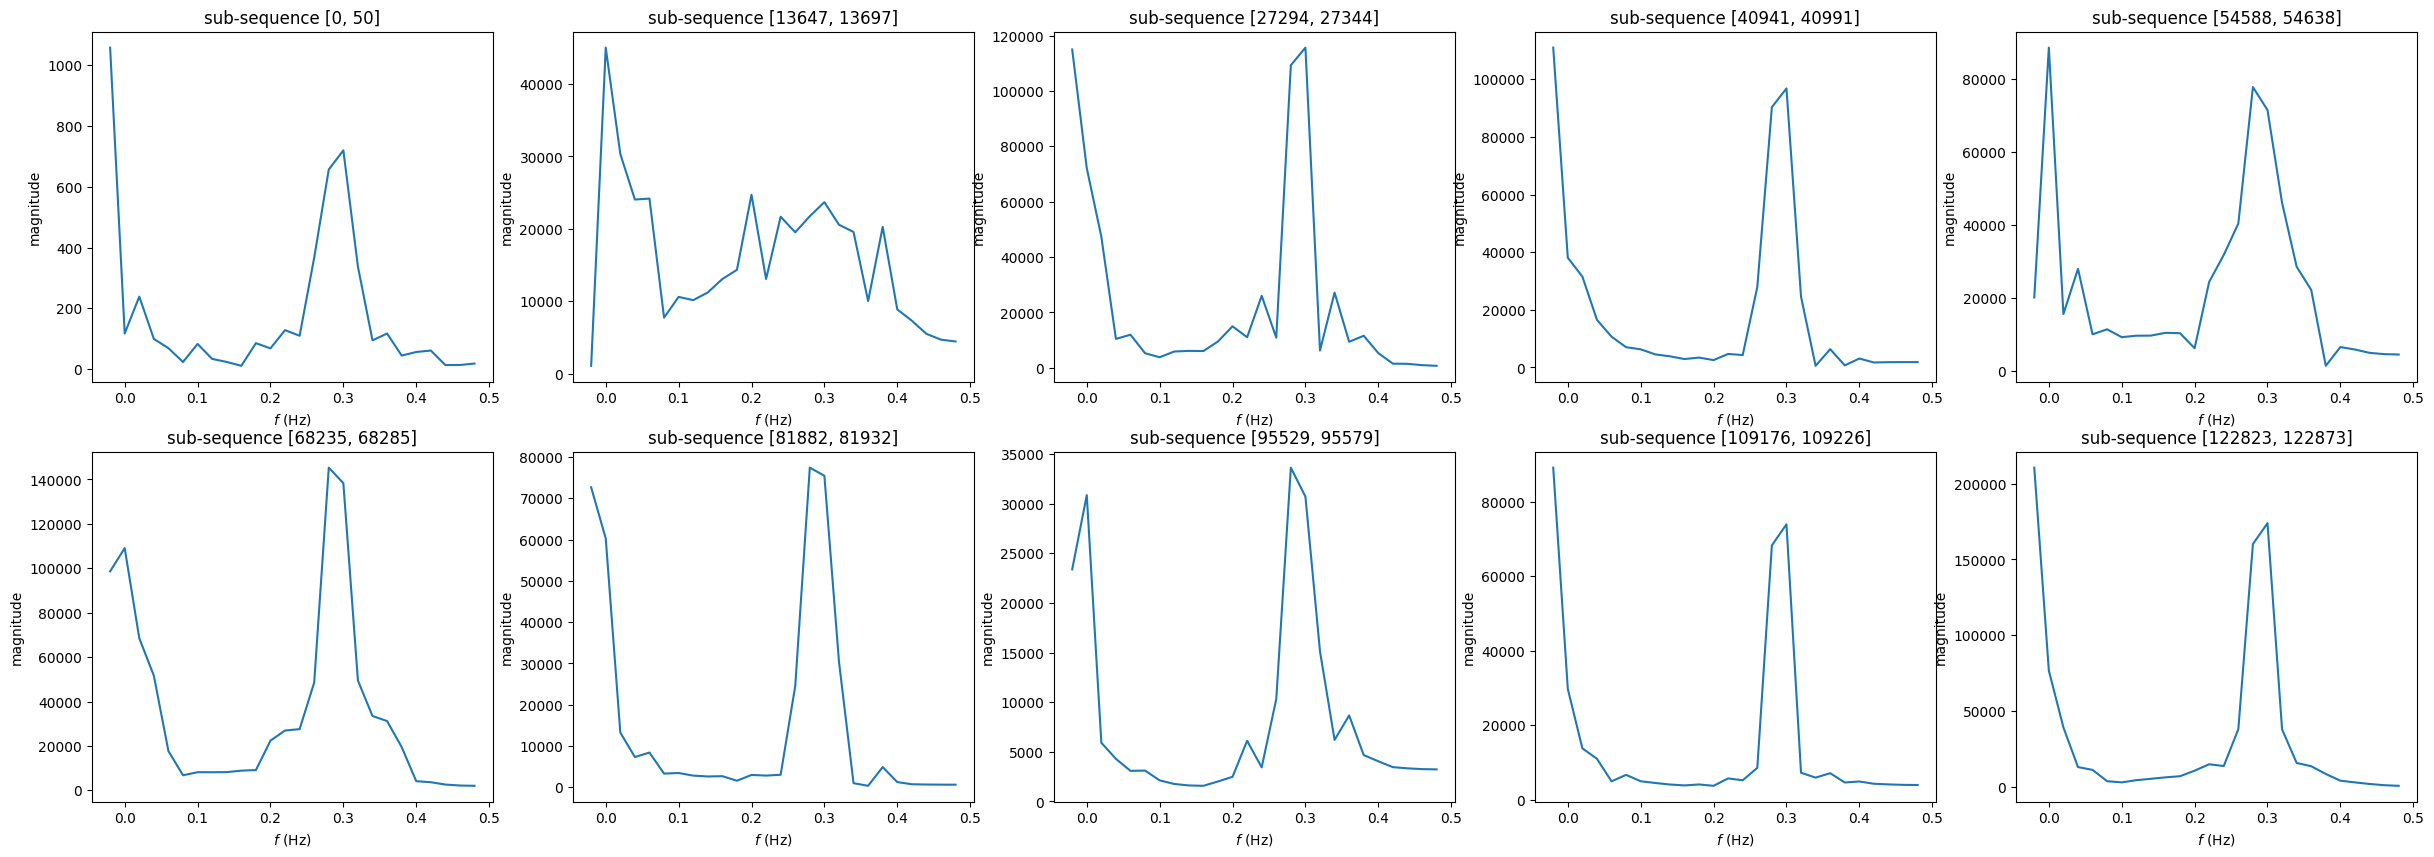

In [8]:
# finding the spectrum information stored in a sub-sequence of length S in the received signal

# jammed_signal = np.concatenate((np.zeros(1000), jammed_signal))
fig, axs = plt.subplots(2, 5, figsize=(30,10))

S = 50 # the size/length of a sub-sequence
sep = np.floor(len(jammed_signal)/10).astype(np.uint32) # seperation size between sub-sequences
print(f"seperation between two sub-sequences: {sep} ({type(sep)})")
if sep < 100:
    raise Exception(f"the provided signal is not long enough for the following code")
for i in range(10):
    sub_sequence = jammed_signal[sep*i : sep*i + S]
    axs[i//5, i%5].plot(*Spectrum(sub_sequence))
    axs[i//5, i%5].set_title(f"sub-sequence [{sep*i}, {sep*i + S}]")
    axs[i//5, i%5].set_xlabel("$f$ (Hz)")
    axs[i//5, i%5].set_ylabel("magnitude")

In [5]:
class UniStateReceiverEnv(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a single state environment. 
    i.e., the objective of the agent is going to be find the best filter that maximizes the reward for a fixed signal partition. 
    :param N: FIR filter length, must be an odd integer 
    :param S: buffer size at the receiver
    """

    # define constants 
    MIN_BUFFER_SIZE = 20
    EPISODE_LENGTH  = 100

    def __init__(self, N:int, S:int):
        super(UniStateReceiverEnv, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # filter length 
        if N%2 != 1:
            raise Exception(f"FIR filter length 'N' must be an odd integer: given {N}")
        self.N = N

        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than the MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S
        # buffer size 
        self.buffer_size = S + N - 1

        # ----------------------------- Action Space -----------------------------
        # action - choosing the filter coefficients from index 0 to (N-1)/2; 
        # NOT TUNING/ADJUSTING/CHANGING the coefficeints of an existing filter that the agent is not aware of 
        action_shape = (int((N+1)/2), )
        self.action_space = spaces.Box(low=-1, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32

        # ----------------------------- State Space ------------------------------
        state_shape = (self.buffer_size, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------------- other class atributes ------------------------
        self.state = jammed_signal[:self.buffer_size] # fixed state
        self.counter = 0 # a counter to keep track of the number of elapsed time steps of the environment

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=None)

        # set the agent back to the initial state 
        # in this case, we have only one state in the entire environment
        initial_state = self.state

        if options == 'reset_counter':
            self.counter = 0

        info = {}

        # return the initial state
        # make sure that the state returned by env.reset() is same as the end state of the previous episode to emulate a non-episodic agent-env interaction. 
        return initial_state, info

    def step(self, action):

        # increment the counter
        self.counter += 1

        # create the filter 
        filter = np.concatenate((action[-1:0:-1], action))

        # receive signal partition in the buffer
        partition = self.state

        # apply the filter 
        filtered = apply_filter(filter, partition)[(self.N-1)//2 : (self.N-1)//2 + self.S]
        target   = target_signal[(self.N-1)//2 : (self.N-1)//2 + self.S]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            raise Exception("reward value is not a number...")
        
        # truncating the episode
        truncated = False
        if self.counter % self.EPISODE_LENGTH == 0:
            truncated = True
        
        next_state = self.state 
        terminated = False
        info = {}
        
        return next_state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass


..... saving models .....
episode:0, score:-722.3916, avg score:-722.3916
average action: [-0.24123164 -0.6274025   0.6002772 ]
..... saving models .....
episode:1, score:-367.4754, avg score:-544.9335
average action: [ 0.6884375  -0.64923745  0.6737698 ]
episode:2, score:-470.433, avg score:-520.1
average action: [ 0.68671316 -0.54184186  0.6770957 ]
episode:3, score:-490.9845, avg score:-512.8211
average action: [ 0.5964901  -0.41821724  0.6482948 ]
episode:4, score:-459.0903, avg score:-502.075
average action: [ 0.5855055 -0.5545485  0.6188664]
episode:5, score:-424.3227, avg score:-489.1163
average action: [ 0.6252793  -0.65391654  0.5654319 ]
episode:6, score:-462.2708, avg score:-485.2812
average action: [ 0.60118073 -0.6074008   0.62873805]
episode:7, score:-547.4671, avg score:-493.0544
average action: [ 0.5736405  -0.5575914   0.55527234]
episode:8, score:-500.1723, avg score:-493.8453
average action: [ 0.62604654 -0.5732189   0.61550313]
episode:9, score:-409.2991, avg score:

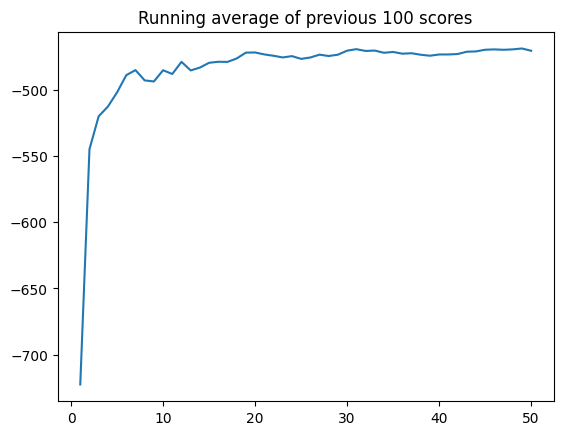

In [11]:
if __name__ == '__main__':
    env = UniStateReceiverEnv(N=5, S=100)
    
    agent = DDPGAgent(
        input_dims=env.observation_space.shape,
        n_actions=env.action_space.shape[0],
        alpha=0.01,
        beta=0.1,
        gamma=0,
        tau=0.001,
        critic_fc1=20,
        critic_fc2=10,
        actor_fc1=128,
        actor_fc2=128,
        batch_size=64,
        buffer_size=10_000,
        noise=1.0
    )
    n_episodes = 50

    figure_file = 'plots/pendulum.png'
    best_score = env.reward_range[0] # minimum reward possible
    score_history = []
    load_checkpoint = False

    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation, _ = env.reset()
            action = env.action_space.sample()
            new_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            agent.remember(observation, action, reward, new_observation, done)
            n_steps += 1
        agent.learn()
        # your model is only going to completely created when learned
        # the input layer of the critic network is only initialized when started training. 
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    observation, _ = env.reset()
    # action_before_training = agent.choose_action(observation, evaluate=True)
    for i in range(n_episodes):
        done = False
        score = 0
        action_buffer = []
        while not done:
            action = agent.choose_action(observation, evaluate)
            action_buffer.append(action)
            new_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            score += reward
            agent.remember(observation, action, reward, new_observation, done)
            if not load_checkpoint:
                agent.learn()
            observation = new_observation
        score_history.append(score)
        avg_score = np.mean(score_history[-10:])

        if score> best_score:
            best_score = score
            if not load_checkpoint:
                agent.save_models()

        print(f"episode:{i}, score:{np.round(score, 4)}, avg score:{np.round(avg_score, 4)}")
        print(f"average action: {np.mean(np.array(action_buffer), axis=0)}")

    if not load_checkpoint:
        x = np.arange(1, 1+n_episodes)
        plot_learning_curve(x, score_history, figure_file)

    action_after_training = agent.choose_action(observation, evaluate=True)
